### Dataset Used: https://www.kaggle.com/datasets/andrewmvd/car-plate-detection

In [282]:
%matplotlib inline

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import cv2
import os
import tensorflow as tf
import glob

In [283]:
IMAGE_SIZE = 200

In [284]:
img_dir = "../input/car-plate-detection/images" # Enter Directory of all images 
data_path = os.path.join(img_dir,'*g')
files = glob.glob(data_path)
files.sort() #We sort the images in alphabetical order to match them to the xml files containing the annotations of the bounding boxes
X=[]
for f1 in files:
    img = cv2.imread(f1)
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    X.append(np.array(img))
    

We create the variable y containing all the bounding boxe annotations (label). 
Before that, we will have to resize the annotations so that it fits the new size of the images (200*200). We create a function resizeannotation for that. 

In [285]:
from lxml import etree
def resizeannotation(f):
    tree = etree.parse(f)
    for dim in tree.xpath("size"):
        width = int(dim.xpath("width")[0].text)
        height = int(dim.xpath("height")[0].text)
    for dim in tree.xpath("object/bndbox"):
        xmin = int(dim.xpath("xmin")[0].text)/(width/IMAGE_SIZE)
        ymin = int(dim.xpath("ymin")[0].text)/(height/IMAGE_SIZE)
        xmax = int(dim.xpath("xmax")[0].text)/(width/IMAGE_SIZE)
        ymax = int(dim.xpath("ymax")[0].text)/(height/IMAGE_SIZE)
    return [int(xmax), int(ymax), int(xmin), int(ymin)]
        

In [286]:
path = '../input/car-plate-detection/annotations'
text_files = ['../input/car-plate-detection/annotations/'+f for f in sorted(os.listdir(path))]
y=[]
for i in text_files:
    y.append(resizeannotation(i))

In [287]:
resizeannotation("/kaggle/input/car-plate-detection/annotations/Cars147.xml")

[168, 126, 90, 93]

In [288]:
y[0]

[167, 129, 90, 93]

We check X et y shape

In [289]:
np.array(X).shape

(433, 200, 200, 3)

In [290]:
np.array(y).shape

(433, 4)

And we display the first eighteen image of the dataset : 

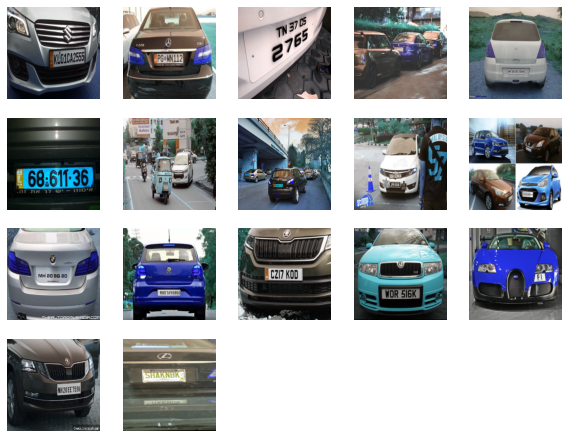

In [291]:
plt.figure(figsize=(10,20))
for i in range(0,17) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(X[i])

We can draw the rectangle containing the license plate using the OpenCV library

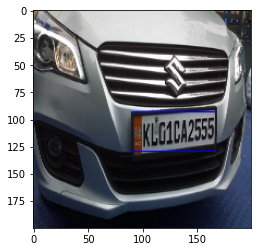

In [292]:
#Example with the first image of the dataset
image = cv2.rectangle(X[0],(y[0][0],y[0][1]),(y[0][2],y[0][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


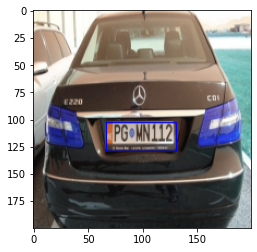

In [293]:
#Example with the second image of the dataset
image = cv2.rectangle(X[1],(y[1][0],y[1][1]),(y[1][2],y[1][3]),(0, 0, 255))
plt.imshow(image)
plt.show()


We prepare the data for the CNN :

In [294]:
#Transforming in array
X=np.array(X)
y=np.array(y)

In [295]:
X[0].shape

(200, 200, 3)

In [296]:
#Renormalisation
X = X / 255
y = y / 255

We split our dataset in two : training set/testing set

In [297]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

## Convolutionnal Neural Network

In [298]:
from keras.models import Sequential

from keras.layers import Dense, Flatten

from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import preprocess_input
from keras import applications


In [299]:
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_13 (Flatten)         (None, 18432)             0         
_________________________________________________________________
dense_49 (Dense)             (None, 128)               2359424   
_________________________________________________________________
dense_50 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_51 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_52 (Dense)             (None, 4)                 260       
Total params: 17,099,140
Trainable params: 2,384,452
Non-trainable params: 14,714,688
_________________________________

In [300]:
model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])


In [301]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


In [302]:
check=tf.keras.callbacks.ModelCheckpoint("/kaggle/working/model.h5", 
                                     monitor='val_accuracy', 
                                     verbose=0, 
                                     save_best_only=True,
                                     save_weights_only=True, 
                                     mode='auto', 
                                     save_freq='epoch')
stop=tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                min_delta=0, 
                                patience=2, 
                                verbose=1, 
                                mode='auto', 
                                baseline=None, 
                                restore_best_weights=True)

In [303]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import Callback


In [304]:
# NanStop = TerminateOnNaN()
LrValAccuracy = ReduceLROnPlateau(monitor='val_accuracy', patience=1, factor= 0.9, mode='max', verbose=1)
# Decrease lr by 10% 

In [306]:
list_of_callbacks=[LrValAccuracy,check,stop]

In [309]:
train = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=6,batch_size=32,callbacks=list_of_callbacks)

Epoch 1/6
13/13 [==============================] - 1s 64ms/step - loss: 0.0017 - accuracy: 0.8612 - val_loss: 0.0044 - val_accuracy: 0.7045
Epoch 2/6
13/13 [==============================] - 1s 61ms/step - loss: 0.0014 - accuracy: 0.8997 - val_loss: 0.0039 - val_accuracy: 0.8636
Epoch 3/6
13/13 [==============================] - 1s 61ms/step - loss: 9.5786e-04 - accuracy: 0.9254 - val_loss: 0.0035 - val_accuracy: 0.8864
Epoch 4/6
12/13 [==========================>...] - ETA: 0s - loss: 6.3352e-04 - accuracy: 0.9375
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005904900433961303.
13/13 [==============================] - 1s 57ms/step - loss: 7.0814e-04 - accuracy: 0.9357 - val_loss: 0.0042 - val_accuracy: 0.7500
Epoch 5/6
13/13 [==============================] - 1s 60ms/step - loss: 0.0010 - accuracy: 0.9126 - val_loss: 0.0034 - val_accuracy: 0.9091
Epoch 6/6
12/13 [==========================>...] - ETA: 0s - loss: 7.7761e-04 - accuracy: 0.9245
Epoch 00006: ReduceLROnPlate

In [310]:
# Test
scores = model.evaluate(X_test, y_test, verbose=0)
print("Score : %.2f%%" % (scores[1]*100))

Score : 90.91%


In [321]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Training Accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation Accuracy')
    plt.title('Scores')
    plt.legend()
    plt.show()

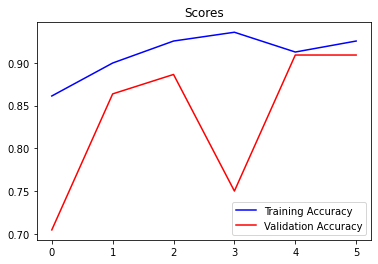

In [322]:
plot_scores(train)

## DETECTION 

In [313]:
y_cnn = model.predict(X_test)

In [314]:
y_cnn.shape

(44, 4)

We can see how our model localize license plates on our testing set :

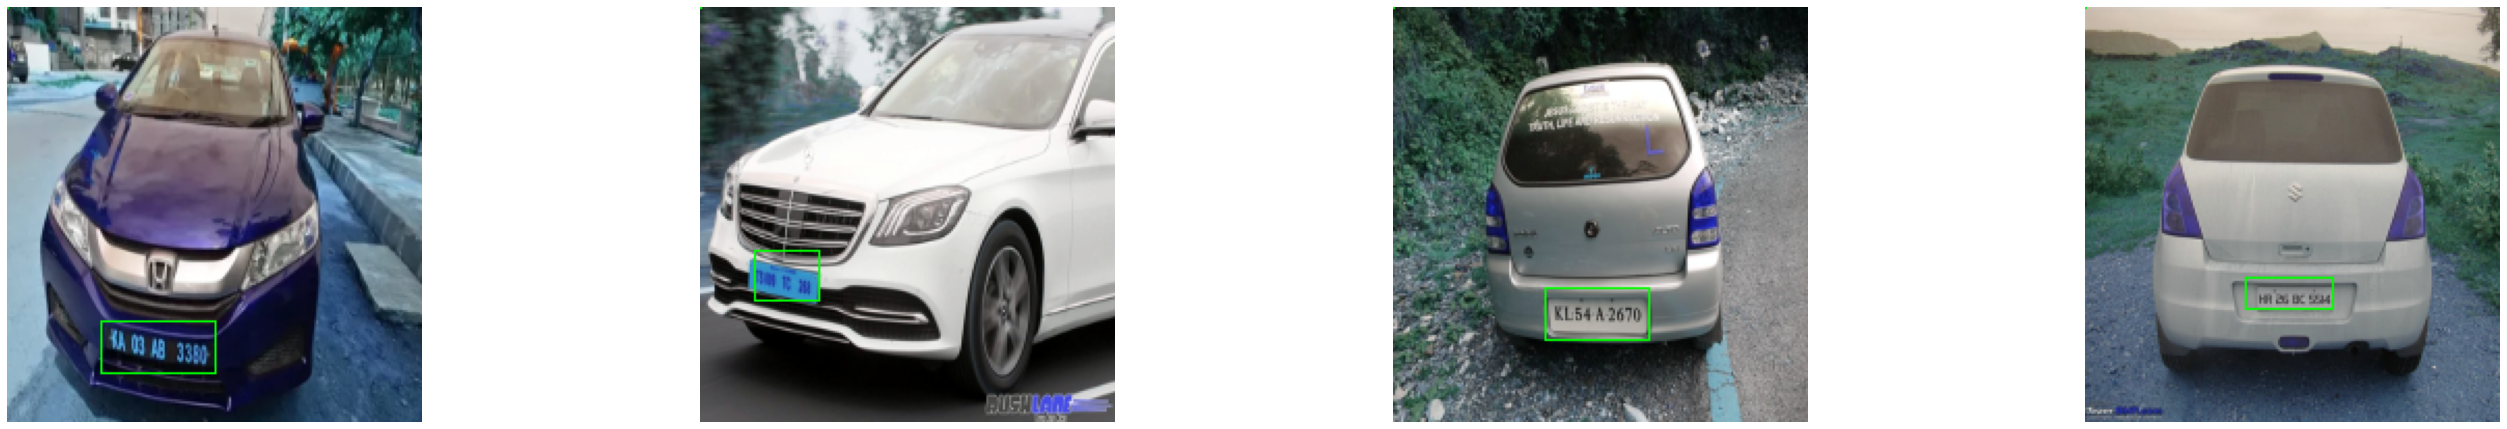

In [320]:
plt.figure(figsize=(60,90))
for i in range(6,10) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = y_cnn[i]
    image = cv2.rectangle(X_test[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)
